In [1]:
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import default_collate # Not used here as we use a mapper, but can be used to collate elements in a batch

from torchdata.nodes.adapters import IterableWrapper
from torchdata.nodes.batch import Batcher
from torchdata.nodes.map import Mapper

import matplotlib.pyplot as plt

## Loading the MNIST dataset

In [2]:
dataset = load_dataset("ylecun/mnist") 
dataset = dataset.with_format("torch")

##### Splitting into train and test

In [3]:
train_dataset = dataset["train"].shuffle()
test_dataset = dataset["test"].shuffle()


train_node = IterableWrapper(train_dataset)
test_node = IterableWrapper(test_dataset)



##### Let's display one image

Image size: torch.Size([1, 28, 28])
Label: 3, label size: torch.Size([])


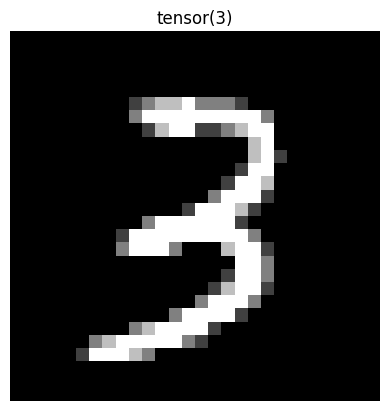

In [4]:

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
img, label = train_dataset["image"][random_idx], train_dataset["label"][random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [5]:
print("length of Train Datasets: ", len(train_dataset))
print("length of Validation Datasets: ", len(test_dataset))

length of Train Datasets:  60000
length of Validation Datasets:  10000


In [7]:

torch.manual_seed(0)
num_classes = len(torch.unique(train_dataset["label"]))

# Hyperparameters
batch_size = 2
num_epochs = 10
learning_rate = 0.001



##### Now we will create a Batcher object, that will pass us the batches while training and testing

In [8]:
train_batcher = Batcher(train_node, batch_size, drop_last=True)
test_batcher = Batcher(test_node, batch_size, drop_last=True)


In [10]:
train_batcher.reset()
for batch in train_batcher:
    print(batch)
    print(default_collate(batch))
    break

[{'image': tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,  20,  13,   0,  16, 193, 147,  19,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0

##### We define a map function to make some changes to the dtype of x, this map fn can be passed into the Mapper

In [8]:
def map_fn(batch):
    x = [item["image"].to(torch.float32) for item in batch]  # List of image tensors
    y = [item["label"] for item in batch]  # List of label tensors
    return torch.stack(x), torch.stack(y)
train_mapper = Mapper(train_batcher, map_fn)
test_mapper = Mapper(test_batcher, map_fn)

##### Defining a simple CNN
###### The NN is just for demonstration and more efficient and accurate archs might exist

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = out.view(-1, 320)
        out = self.fc_block(out)
        return out

In [10]:
# Initialize the neural network and loss function
model = Net().to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Train the model
loss_list = []
accuracy_list = []
for epoch in range(num_epochs):
    print(f"epoch = {epoch}")
    train_mapper.reset()
    num_loops = 0
    total_loss = 0
    for images, labels in train_mapper:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (num_loops+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{num_loops+1}], Loss: {loss.item():.4f}')
        total_loss+=loss.item()
        num_loops+=1
    total_loss /=num_loops
    loss_list.append(total_loss)
    
    # Test the model
    test_mapper.reset()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_mapper:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            
        acc = 100.0 * n_correct / n_samples
        accuracy_list.append(acc)
        print(f'Test Accuracy: {acc} %')

epoch = 0
Epoch [1/10], Step [50], Loss: 0.5780
Epoch [1/10], Step [100], Loss: 0.2994
Epoch [1/10], Step [150], Loss: 0.4244
Epoch [1/10], Step [200], Loss: 0.1718
Epoch [1/10], Step [250], Loss: 0.1693
Epoch [1/10], Step [300], Loss: 0.1736
Epoch [1/10], Step [350], Loss: 0.1018
Epoch [1/10], Step [400], Loss: 0.2739
Epoch [1/10], Step [450], Loss: 0.1410
Test Accuracy: 96.3641826923077 %
epoch = 1
Epoch [2/10], Step [50], Loss: 0.0711
Epoch [2/10], Step [100], Loss: 0.1020
Epoch [2/10], Step [150], Loss: 0.2640
Epoch [2/10], Step [200], Loss: 0.0221
Epoch [2/10], Step [250], Loss: 0.0913
Epoch [2/10], Step [300], Loss: 0.0879
Epoch [2/10], Step [350], Loss: 0.1413
Epoch [2/10], Step [400], Loss: 0.1759
Epoch [2/10], Step [450], Loss: 0.1233
Test Accuracy: 97.62620192307692 %
epoch = 2
Epoch [3/10], Step [50], Loss: 0.0518
Epoch [3/10], Step [100], Loss: 0.0305
Epoch [3/10], Step [150], Loss: 0.1391
Epoch [3/10], Step [200], Loss: 0.0550
Epoch [3/10], Step [250], Loss: 0.1324
Epoch [

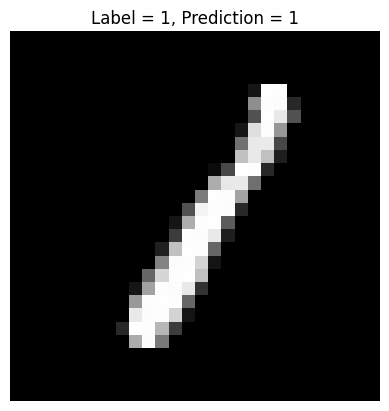

In [12]:

torch.manual_seed(42)
random_idx = torch.randint(0, len(images), size=[1]).item()
img, label , prediction= images[random_idx], labels[random_idx], predicted[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label = {label}, Prediction = {prediction}")
plt.axis("Off");

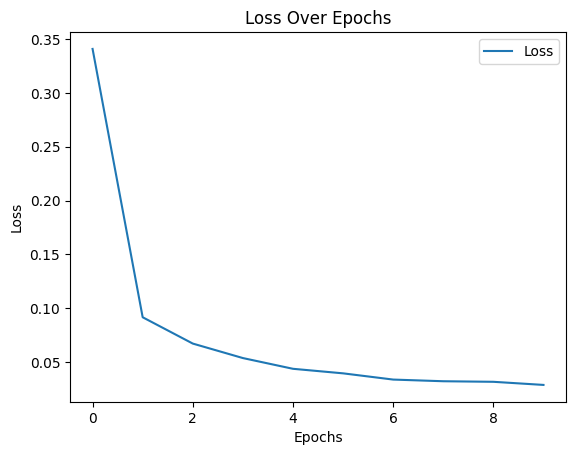

In [13]:
plt.plot(loss_list, label='Loss')


plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()

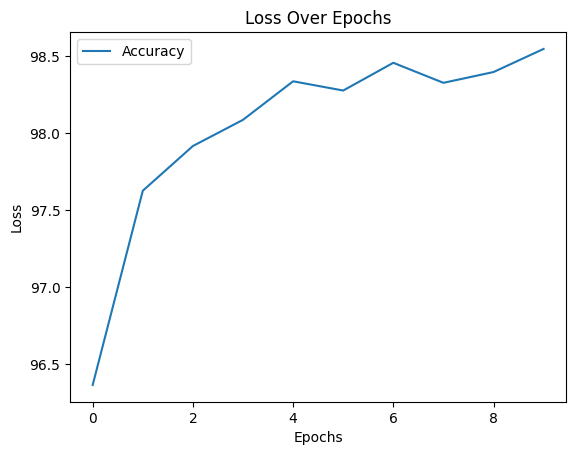

In [14]:
plt.plot(accuracy_list, label='Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()